# Assignment 2: Experimentation & Model Training
Authors: Naomi Buell and Richie Rivera

*Assignment*

*This assignment consists of conducting at least two (2) experiments for different algorithms: Decision Trees, Random Forest and Adaboost. That is, at least six (6) experiments in total (3 algorithms x 2 experiments each). For each experiment you will define what you are trying to achieve (before each run), conduct the experiment, and at the end you will review how your experiment went. These experiments will allow you to compare algorithms and choose the optimal model.*

*Using the dataset and EDA from the previous assignment, perform the following:*

1. *Algorithm Selection:*
*You will perform experiments using the following algorithms:*
- *Decision Trees*
- *Random Forest*
- *Adaboost*

2. *Experiment:*
*For each of the algorithms (above), perform at least two (2) experiments. In a typical experiment you should:*
- *Define the objective of the experiment (hypothesis)*
- *Decide what will change, and what will stay the same*
- *Select the evaluation metric (what you want to measure)*
- *Perform the experiment*
- *Document the experiment so you compare results (track progress)*

3. *Variations:*
*There are many things you can vary between experiments, here are some examples:*

- *Data sampling  (feature selection)*
- *Data augmentation e.g., regularization, normalization, scaling*
- *Hyperparameter optimization (you decide, random search, grid search, etc.)*
- *Decision Tree breadth & depth (this is an example of a hyperparameter)*
- *Evaluation metrics e.g., Accuracy, precision, recall, F1-score, AUC-ROC*
- *Cross-validation strategy e.g., holdout, k-fold, leave-one-out*
- *Number of trees (for ensemble models)*
- *Train-test split: Using different data splits to assess model generalization ability*

## EDA Recap

### Load Libraries and Dataset

First, we import libraries and load the Portuguese banking dataset.

In [19]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import accuracy_score
import numpy as np
import zipfile
import io
import requests

In [2]:
# Download the zip file from the internet
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
response = requests.get(url)

# Extract bank-additional.zip from the downloaded zip
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('bank-additional.zip') as additional_zip_file:
        with zipfile.ZipFile(additional_zip_file) as additional_zip:
            # Extract bank-additional-full.csv from bank-additional.zip
            with additional_zip.open('bank-additional/bank-additional-full.csv') as csvfile:
                df = pd.read_csv(csvfile, sep=';')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Handle Missing Values

There are some observations set as "unknown" in several categorical columns. Additionally, the `pdays` column has a value of 999 which means the client was not previously contacted. We will treat these as missing values.

In [3]:
# Check for categorical variables that are "unknown" and replace 'unknown' with np.nan in all object (categorical) columns
df_nas = df.copy()
df_nas = df_nas.replace('unknown', np.nan)
df_nas = df_nas.replace(999, np.nan)  # Replace 999 in 'pdays' with np.nan

# Check for categorical variables that are now NA
na_counts = df_nas.isna().sum()
na_counts = na_counts[na_counts > 0].sort_values(ascending=False)
na_perc = (na_counts / len(df_nas)) * 100
print("Columns with NA values and their % missing:")
print(na_perc.round(2))

Columns with NA values and their % missing:
pdays        96.32
default      20.87
education     4.20
housing       2.40
loan          2.40
job           0.80
marital       0.19
duration      0.00
dtype: float64


`pdays` is now 96% missing in cases where the client has not been previously contacted. `default` (whether or not the client has credit in default) has significant missingness. `education` (education level), `housing` (whether the client has a housing loan), `loan` (whether the client has a personal loan), `job` (type of job), and `marital` (marital status) have some minor missingness. We will address this missingness next.



We drop `default`, whether the client has credit in default, since it is 21% missing and there is little risk of losing valuable information that our classifier needs to discriminate between classes (most clients with known data are not in default. 79% no, <1% yes, 20% unknown). We also drop `pdays` (number of days that passed by after the client was last contacted from a previous campaign) since it is 96% missing and was determined to be not useful for prediction according to the IV. For the other columns with minor missingness (`education`, `housing`, `loan`, `job`, and `marital`), we will drop rows with missing data. Since the missingness is low, we will not lose much information by dropping these rows. We also drop the `duration` column, the last contact duration in seconds, because this attribute highly affects the output target (e.g., if duration=0 then y="no"). Per the bank data notes, this input should be discarded for our predictive model.

In [4]:
# Save a new dataframe for preprocessing
df_dropped = df_nas.copy()

# Remove `default` and `pdays` columns due to high missingness. Drop duration per data notes.
df_dropped = df_dropped.drop(columns=['default', 'pdays', 'duration'])

# Drop rows with missing values in other columns
df_dropped = df_dropped.dropna()

# Display ns before and after dropping missing values
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_dropped.shape}")

Original dataset shape: (41188, 21)
Cleaned dataset shape: (38245, 18)


We still have sufficient data to run a decision tree, random forest, and AdaBoost model with, even after removing rows with missing values. 

### Handle Categorical Features

Next, we map ordinal categorical variables to numeric values. In this case, we map the education levels to estimated number of years of schooling.

In [5]:
df_fe = df_dropped.copy()

# Map education levels to numeric values
education_mapping = {
    'illiterate': 0,                # 0 years
    'basic.4y': 4,                  # 4 years
    'basic.6y': 6,                  # 6 years
    'basic.9y': 9,                  # 9 years
    'high.school': 12,              # 12 years (typical for high school)
    'professional.course': 14,      # 14 years (post-secondary/professional)
    'university.degree': 16         # 16 years (bachelor's degree)
}
df_fe['education'] = df_fe['education'].map(education_mapping)

We also perform label encoding on other categorical variables before we feed data to tree-based machine learning algorithms.

In [12]:
df_encoded = df_fe.copy()
for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
    class_le = LabelEncoder()
    df_encoded[col] = class_le.fit_transform(df_encoded[col])

df_encoded.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,4,0,0,1,6,1,1,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,12,0,0,1,6,1,1,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,12,1,0,1,6,1,1,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,6,0,0,1,6,1,1,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,12,0,1,1,6,1,1,0,1,1.1,93.994,-36.4,4.857,5191.0,0


We can now move onto the model training and experimentation section.

> Noting that since tree-based models do not need standardization, one-hot encoding, PCA, or data balancing, we did not include this step in our EDA, even though we did perform it in our previous assignment.

## Decision Trees

### Experiment 1

**Objective**: To test different data sampling techniques to determine the most relevant variables in a decision tree model predicting customers' decision to subscribe to the bank's term deposit.

**Variation tested**: Decision tree with max depth of 4, using all features, split 70% training and 30% testing.

**Evaluation metric**: Classification accuracy in terms of the fraction of correctly classified samples, using `accuracy_score` from `sklearn.metrics`.

**Test**: 

In [13]:
# Separate features and target
X = df_encoded.drop(columns=['y'])
y = df_encoded['y']

# Randomly split the X and y arrays into 30 percent test data and 70 percent training data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

# Create and fit a decision tree model
tree_model = DecisionTreeClassifier(criterion='gini',
                                     max_depth=4,
                                     random_state=1)
tree_model.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

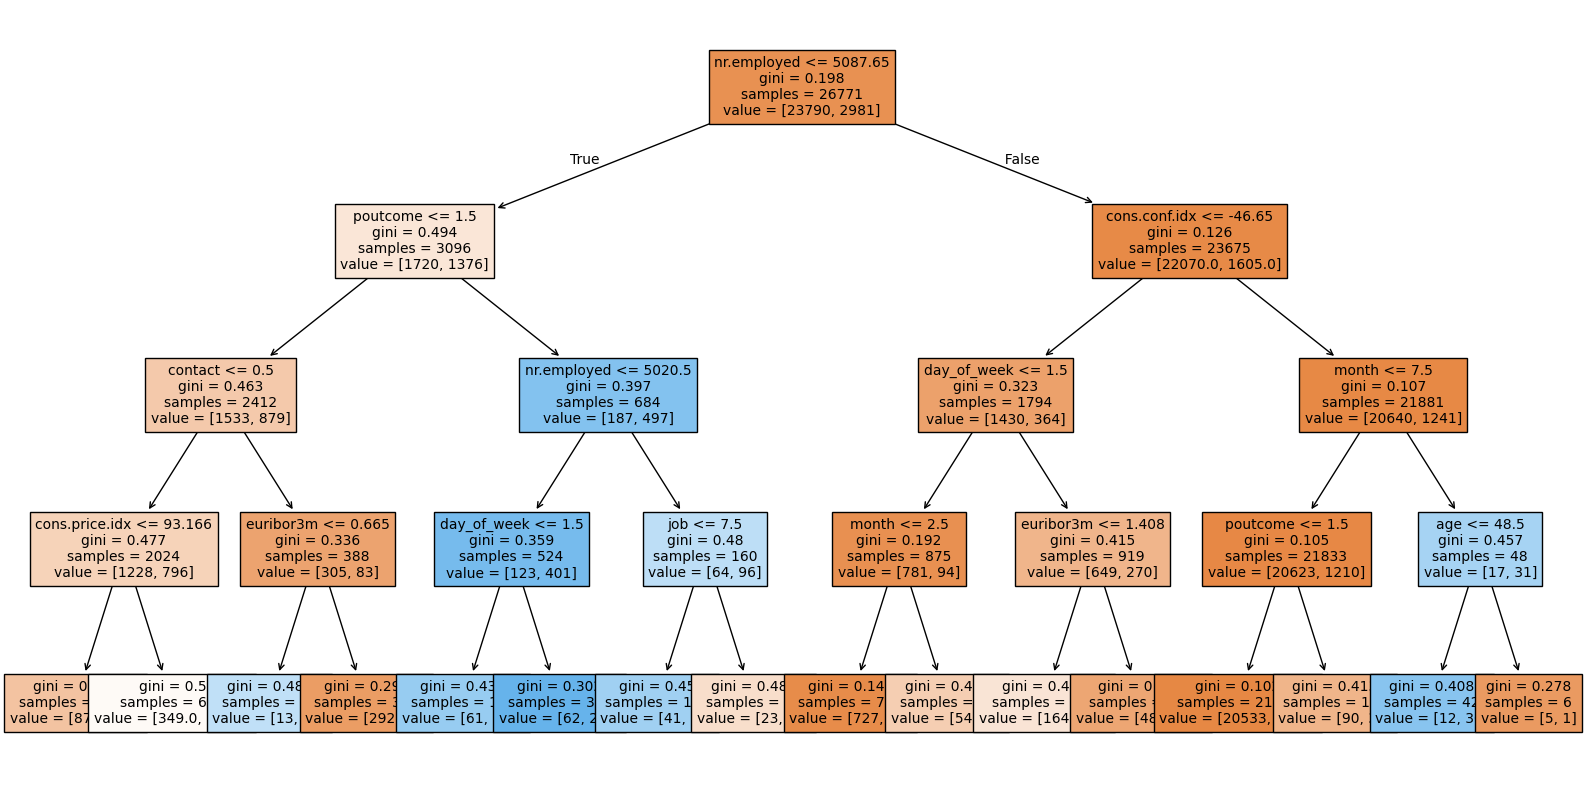

In [18]:
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_model, filled=True, feature_names=list(X.columns), fontsize=10)
plt.show()

In [27]:
y_pred = tree_model.predict(X_test)
print('Accuracy (the fraction of correctly classified samples): %.3f' % accuracy_score(y_test, y_pred))

Accuracy (the fraction of correctly classified samples): 0.900


**Result**:

**Recommendation**:

### Experiment 2

**Objective**:

**Variation tested**:

**Evaluation metric**:

**Test**: 

**Result**:

**Recommendation**:

## Random Forest

### Experiment 1

**Objective**:

**Variation tested**:

**Evaluation metric**:

**Test**: 

**Result**:

**Recommendation**:

### Experiment 2

**Objective**:

**Variation tested**:

**Evaluation metric**:

**Test**: 

**Result**:

**Recommendation**:

## Adaboost

### Experiment 1

**Objective**:

**Variation tested**:

**Evaluation metric**:

**Test**: 

**Result**:

**Recommendation**:

### Experiment 2

**Objective**:

**Variation tested**:

**Evaluation metric**:

**Test**: 

**Result**:

**Recommendation**: